# Data Cleaning - Spray and Weather Dataset

In this notebook, we perform data cleaning on the spray and weather dataset. We also perform preliminary analysis on the data and perform some feature engineering based on our review. 

Contents:
- [Spray Dataset](#Spray-Dataset)
  - [Imports](#Import-libraries-and-data)
  - [Apply grid over map of spray locations](#Create-a-grid-over-map-of-spray-location)
  - [Deal with null values](#Deal-with-null-values-in-spray)
  - [Save cleaned spray dataset](#Save-cleaned-spray-data)
- [Weather Dataset](#Weather-Dataset)
  - [Read data](#Read-data)
  - [Data formatting](#Data-formatting)
  - [Deal with null values in weather](#Deal-with-null-values-in-weather)
  - [Station reference](#Station-reference)
  - [Feature Engineering](#Feature-engineering)
  - [Save cleaned weather dataset](#Save-cleaned-weather-data)

### <u>Spray Dataset</u>
### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read spray csv file and preview
spray = pd.read_csv("../data/raw/spray.csv")
display(spray.head(10))
print("Shape of spray set: ", spray.shape)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995


Shape of spray set:  (14835, 4)


In [3]:
spray.groupby('Date')['Date'].count()

Date
2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: Date, dtype: int64

Spraying efforts were made only on 10 days in 2011 and 2013.

### Create a grid over map of spray location
We create a grid over the map to identify grids where spraying efforts were made. Then create a column for grid number for the respective spraying locations.

In [4]:
# find the maximum and minimum latitude and longitude of spray locations
coord_stats3={}
coord_stats3["long_max"] = spray['Longitude'].max()
coord_stats3["long_min"] = spray['Longitude'].min()
coord_stats3["lat_max"] = spray['Latitude'].max()
coord_stats3["lat_min"] = spray['Latitude'].min()
coord_stats3

{'long_max': -87.58672666666669,
 'long_min': -88.0964683333333,
 'lat_max': 42.3959833333333,
 'lat_min': 41.713925}

In [5]:
# From train and test sets, get the maximum and minimum coordinates where 
coord_stats1 = {'long_max': -87.531635,
 'long_min': -87.930995,
 'lat_max': 42.01743,
 'lat_min': 41.644612}

In [6]:
# function gets the max and min coordinates based on both spray and testing locations
def calculate_coords(a, b):
    stats = {}
    stats["long_max"] = max(a["long_max"], b["long_max"])
    stats["long_min"] = min(a["long_min"], b["long_min"])
    stats["lat_max"] = max(a["lat_max"], b["lat_max"])
    stats["lat_min"] = min(a["lat_min"], b["lat_min"])
    long_range = stats["long_max"] - stats["long_min"]
    lat_range = stats["lat_max"] - stats["lat_min"]
    stats["long_max"] += long_range*0.01
    stats["long_min"] -= long_range*0.01
    stats["lat_max"] += lat_range*0.01
    stats["lat_min"] -= lat_range*0.01    
    
    return stats

In [7]:
# compute 
stats = calculate_coords(coord_stats1, coord_stats3)
stats

{'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

In [8]:
# function to assign a grid number to a particular coordinate based on the range of max/min coordinates

# inputs: long, lat of a particular coordinate
# stats: range of max/min long, lat of an area, in form of dictionary long_max, long_min, lat_max, lat_min
# default: 10x10 grid
# most south western grid is 0, most north eastern grid is 99

def calculate_grid(long, lat, stats):
    row_total = 10
    column_total = 10
    stats = stats
    long_range = stats["long_max"] - stats["long_min"]
    lat_range = stats["lat_max"] - stats["lat_min"]
    row_no = (lat - stats["lat_min"])//(lat_range/row_total)
    column_no = (long - stats["long_min"])//(long_range/column_total)
    grid_no = row_no * column_total + column_no
    
    # error - returns 999
    if ((abs(row_no) > 9) or (abs(column_no) > 9)):
        grid_no = 999
    
    return grid_no

Check extremes of function.

In [9]:
# Testing case of grid 0
long = -88.05
lat = 41.64
stats = {'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

calculate_grid(long, lat, stats)

0.0

In [10]:
# Testing case of grid 999
long = -100
lat = 41.64
stats = {'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

calculate_grid(long, lat, stats)

999

In [11]:
# create a new column for grid_no
grid_no = []
stats = {'long_max': -87.52598666666667,
 'long_min': -88.10211666666663,
 'lat_max': 42.40349704666663,
 'lat_min': 41.63709828666667}

for i in range(len(spray[["Latitude"]])):
    long = spray.loc[i,"Longitude"]
    lat = spray.loc[i,"Latitude"]
    spray.loc[i,"grid_no"] = calculate_grid(long, lat, stats)

In [12]:
spray["grid_no"].value_counts()

45.0    3245
36.0    1824
35.0    1774
46.0    1406
17.0    1385
16.0    1194
18.0    1180
44.0    1071
47.0     999
37.0     609
90.0      95
34.0      53
Name: grid_no, dtype: int64

In [13]:
spray.head()

,Date,Time,Latitude,Longitude,grid_no
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,90.0
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,90.0
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,90.0
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,90.0
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,90.0


### Deal with null values in spray

In [14]:
print(spray.isnull().sum())
print("-----------")
print("Shape of spray dataset: ", spray.shape)

Date           0
Time         584
Latitude       0
Longitude      0
grid_no        0
dtype: int64
-----------
Shape of spray dataset:  (14835, 5)


While there are 584 missing values, these form only about 4% of the full dataset. Further, considering that we will merge this dataset with the train and test sets, time is an irrelevant feature since there aren't any time data on the train and test sets. We will drop this column altogether.

In [15]:
spray.drop(columns =['Time'], inplace = True)

### Save cleaned spray data

In [16]:
spray.to_csv("../data/clean/spray_clean.csv", index = False)

### <u>Weather Dataset</u>

Our analysis will be focused based on domain knowledge on breeding of *Culex* mosquitoes. Historical data has shown that when weather gets dry with intermittent rain, it will favour mosquito breeding.  These mosquitoes also prefer to bite at night (SCAL, 2019). Also in a study, increasing temperatures could generally lead to a more rapid proliferation of *Culex* populations (Entomol, 2015).

### Read data

In [17]:
weather = pd.read_csv("../data/raw/weather.csv")

In [18]:
# preview file
display(weather.head(10))
print("Shape of weather set: ", weather.shape)
print("Data types of weather set: ", weather.dtypes)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


Shape of weather set:  (2944, 22)
Data types of weather set:  Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object


### Data formatting
From here, we convert the date to datetime, replace the placeholder for missing data per the kaggle documentation to NaN and we change the numeric columns to a float datatype. We perform a perliminary review using pandas profiling report as well. 

In [19]:
#generate html summary of report about data
report  = ProfileReport(weather)
report.to_file(output_file = 'weather.html')
print("Report is ready for analysis!")


Report is ready for analysis!


Insights from report on Weather dataset: 

1. While it says that there are no missing data, from the metadata provided in the [NOAA Weather Documentation](https://www.kaggle.com/c/predict-west-nile-virus/data), those that are 'M', left blank, '-' and 'T' are missing data or have sparse/unavailable data. These will be reflected as NaN later.


2. Weather data is obtained from two different stations equally. This means that on a date, two weather records are obtained, 1 from each of the weather stations. A location further away from a particular weather station may not very accurately reflect the weather data recorded. We will consider if there are stark differences between the data of weather station 1 and 2. If so, we will take weather data based on proportion of distance relative to the respective weather stations.


3. There is strong correlation between `tmin`, `tmax`, `tavg`, which is expected. To avoid multicollinearity, we will just use the `tavg` field. On further analysis, there are missing data under tavg which can be computed from tmin and tmax. We will do this prior to dropping `tmin` and `tmax`. To convert `tavg` to numeric as well. 


4. `depart` which refers to departure of temperature from normal, has about 50% of entries of missing data which was reflected as 'M'. On futher analysis of data, this is because only station 1's data was recorded for this. Also, this field is computed by subtracting a reference temperature of 53/54 degrees farenheit from Tavg. We can impute these 'M' values with this computation, using the average (53.5 degrees farenheit), as reference. 


5. `dewpoint` is related to relative humidity which does affect breeding of *Culex* mosquitoes. This shows a relatively high correlation with temperature and the data is normally distributed. We are likely to retain this column and perform further analysis later. 


6. `wetbulb` is the lowest temperature that can be reached under current ambient conditions by evaporation of water only. To convert to numeric.


7. `heat` and `cool` are temperature-related too. We will convert these columns to numeric.


8. `sunrise` and `sunset` is a smilar case with `depart` column, where half of data is not available. When merging with train/test data, to also grab available information from station 1. The hours should not differ as much between both stations. As mosquitos thrive in the dark, sunrise and sunset data would be useful to find darkhours. 


9. `codesum` refers to the weather phenomena. This field has at least 50% missing data and nature of the data is not very useful for moquito breeding analysis beyond which we have considered. So we will drop this column. 


10. `depth` has either 0 value or missing data. `water1` is also not very useful as it only has M in its data. `snowfall` is not likely to help geenrate useful predictions as it's also either 0 or M. These three columns will be dropped. 


11. `preciptotal` is the precipitation level. It has some data labelled as traces but only a small proportion of data (10%). We will assume these as negligible, and impute with a 0.


12. `stnpressure` and `sealevel` is not very relevant to mosquito breeding so we will drop these columns. 


13. `resultspeed`, `resultdir` and `avgspeed` relates to wind speed and direction. Wind speed may affect the humidity of the surroundings so we will keep this column for further analysis. However, we will drop `resultdir` as it is not very relevant. 

In [20]:
# adjust formatting
def reformat(df):
    ''' function that changes the formatting of dataframe by making column names all to lowercase and make the date to datetime format'''
    df.rename(columns = str.lower, inplace = True) #change header to lowercase for easy handling
    df['date'] = pd.to_datetime(df['date']) #change date to date time format
    return df

In [21]:
# reformat weather data
reformat(weather)
display(weather.head())
print("Shape of weather data: ", weather.shape)
print(weather.dtypes)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


Shape of weather data:  (2944, 22)
station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
dtype: object


In [22]:
# drop irrelevant columns
weather.drop(columns = ['codesum', 'depth', 'water1', 'snowfall', 'stnpressure', 'sealevel', 'resultdir'], inplace = True)

In [23]:
# replace placeholder for missing data and traces from kaggle documentation to NaN
for x in weather.columns:
    if weather[x].dtype == "O":
        replacement = [y if ((y!="M") and (y!="-") and (y!="  T") and (y!="T") and (y!="")) else np.NaN for y in weather[x]]
        weather[x] = replacement
        print('replaced "M" and "-" and "  T" in ' + x)   

replaced "M" and "-" and "  T" in tavg
replaced "M" and "-" and "  T" in depart
replaced "M" and "-" and "  T" in wetbulb
replaced "M" and "-" and "  T" in heat
replaced "M" and "-" and "  T" in cool
replaced "M" and "-" and "  T" in sunrise
replaced "M" and "-" and "  T" in sunset
replaced "M" and "-" and "  T" in preciptotal
replaced "M" and "-" and "  T" in avgspeed


In [24]:
weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
preciptotal            object
resultspeed           float64
avgspeed               object
dtype: object

In [25]:
# to change numeric columns to the right data type
features = ["tavg", "depart", "wetbulb", "heat", "cool", "sunrise", "sunset", "preciptotal", "avgspeed"]

In [26]:
# change the data types to float 
for x in features:
    if weather[x].dtype == "O":
        try:
            weather[x] = pd.to_numeric(weather[x])
            print("changed to numeric: " + x)
        except:
            pass

changed to numeric: tavg
changed to numeric: depart
changed to numeric: wetbulb
changed to numeric: heat
changed to numeric: cool
changed to numeric: sunrise
changed to numeric: sunset
changed to numeric: preciptotal
changed to numeric: avgspeed


### Deal with null values in weather

In [27]:
# view the missing values
weather.isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset         1472
preciptotal     320
resultspeed       0
avgspeed          3
dtype: int64

We find that half fields are empty in `Depart`, `Sunrise`, `Sunset`, `Depth`, due to unavailability of data for Station 2. We will consider combining two rows of data on the same date into one, by getting an average of the values for the same day weather data. 

In [28]:
#impute NAs in tavg column
for i,j in weather.iterrows():
    if pd.isnull(j.tavg):
        weather.loc[i,'tavg'] = (j['tmin'] + j['tmax']) / 2 

In [29]:
# no longer require tmin and tmax, so we drop it 
weather.drop(columns = ['tmin', 'tmax'], inplace = True)

In [30]:
#impute NAs in depart column
for i,j in weather.iterrows():
    if pd.isnull(j.depart):
        weather.loc[i,'depart'] = j['tavg'] - 53.5 

In [31]:
weather.isnull().sum()

station           0
date              0
tavg              0
depart            0
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset         1472
preciptotal     320
resultspeed       0
avgspeed          3
dtype: int64

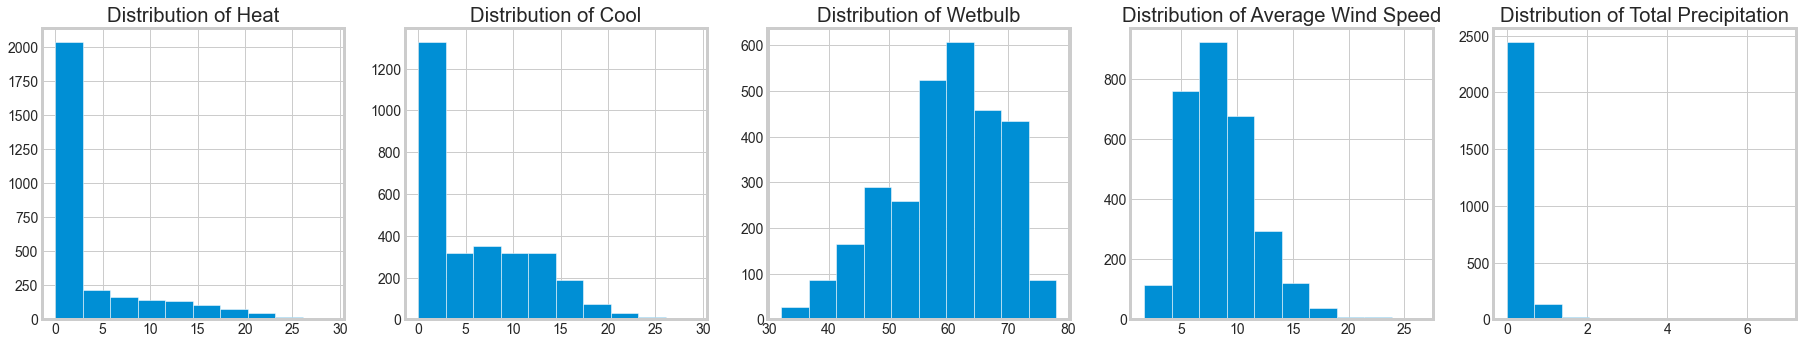

In [32]:
# view distribution of heat, cool, wetbulb, average wind speed and total precipitation
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (28,5))
ax1 = plt.subplot(151)
ax1.hist(weather.heat)
ax1.set_title("Distribution of Heat")
ax2 = plt.subplot(152)
ax2.hist(weather.cool)
ax2.set_title("Distribution of Cool")
ax3 = plt.subplot(153)
ax3.hist(weather.wetbulb)
ax3.set_title("Distribution of Wetbulb")
ax4 = plt.subplot(154)
ax4.hist(weather.avgspeed)
ax4.set_title("Distribution of Average Wind Speed")
ax5 = plt.subplot(155)
ax5.hist(weather.preciptotal)
ax5.set_title("Distribution of Total Precipitation");

From above, it appears that the heat, cool, average and total precipitation column have right-skewed distributions whicle wetblub is left-skewed. As these are not normally distributed, we'll impute the null values with median. 

In [33]:
# impute NAs in columns mentioned above with median
cols = ['heat', 'cool', 'wetbulb', 'avgspeed', 'preciptotal']
for col in cols:
    weather[col].fillna(weather[col].median(), inplace = True)

In [34]:
# impute NAs in sunrise and sunset column
weather.sunrise.fillna(method = 'pad', inplace = True)
weather.sunset.fillna(method = 'pad', inplace = True)

In [35]:
weather.isnull().sum()

station        0
date           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
preciptotal    0
resultspeed    0
avgspeed       0
dtype: int64

### Station reference
Weather dataframe is now clean! Let's look at whether there is a huge difference in data between weather station 1 and weather station 2. If there is, then we will take the proportionate distance of the trap location to the respective station site. Else, we will use weather data from the nearest station. 

In [36]:
# create datetime columns
weather['year'] = weather['date'].apply(lambda x: x.year)
weather['mth'] = weather['date'].apply(lambda x: x.month)
weather['weekofyear'] = weather['date'].apply(lambda x: x.weekofyear)

In [37]:
# separate weather data for station 1 and 2
weather_stn_1 = weather[weather.station == 1]
weather_stn_2 = weather[weather.station == 2]

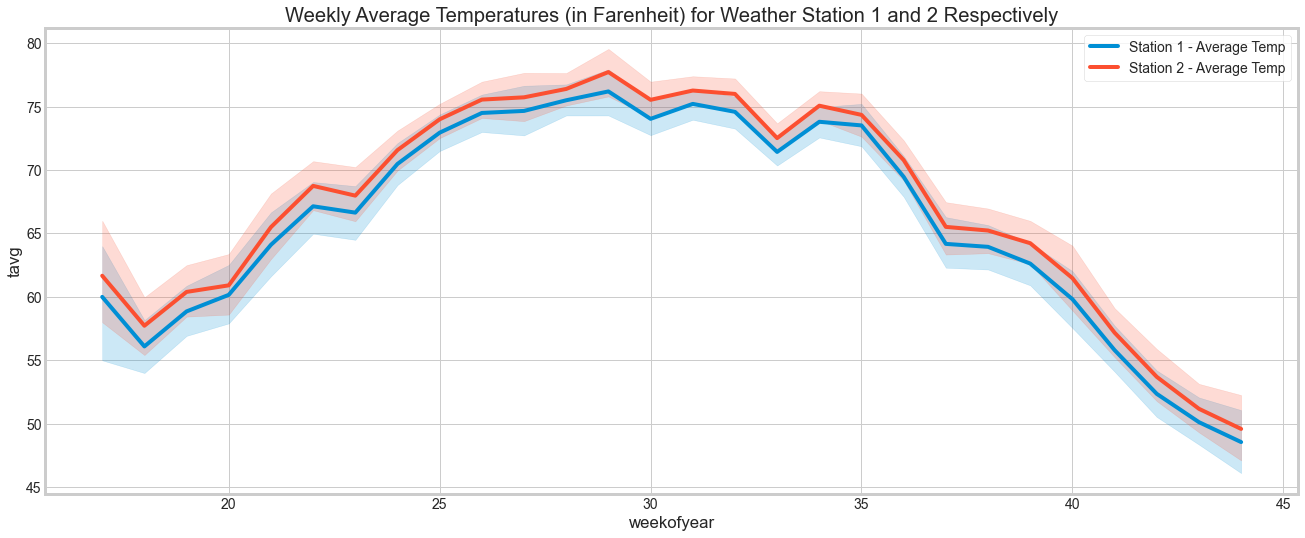

In [38]:
# plot both average temperatures
plt.figure(figsize = (20,8))
sns.lineplot(data = weather_stn_1, x = 'weekofyear', y = 'tavg', label = 'Station 1 - Average Temp', palette = 'forestgreen')
sns.lineplot(data = weather_stn_2, x = 'weekofyear', y = 'tavg', label = 'Station 2 - Average Temp', palette = 'c')
plt.title("Weekly Average Temperatures (in Farenheit) for Weather Station 1 and 2 Respectively");

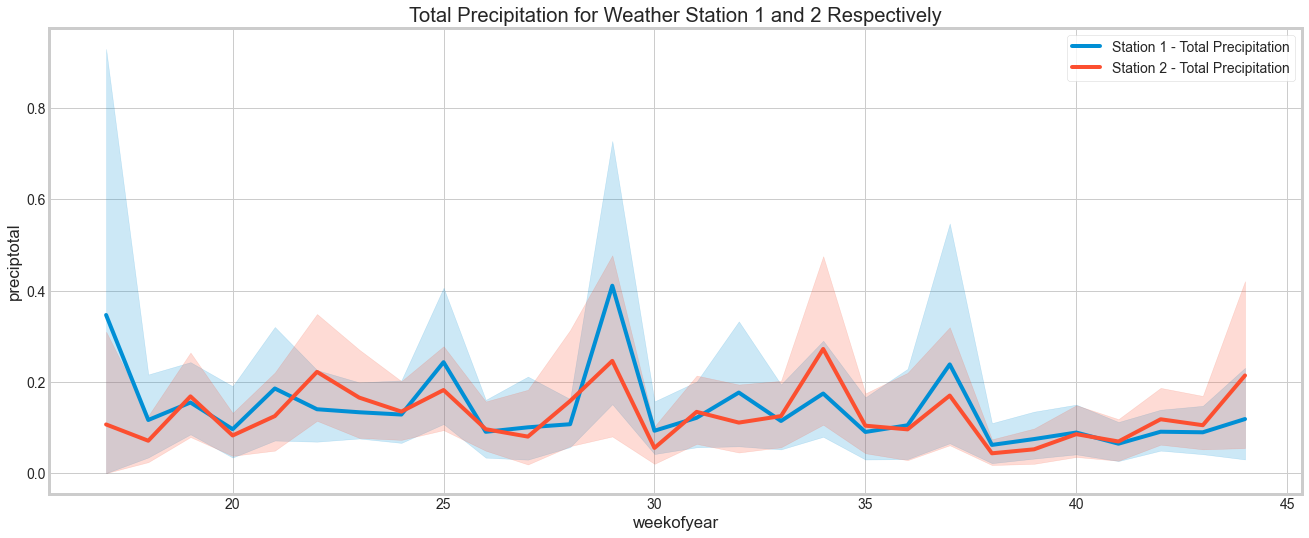

In [39]:
# plot both total precipitation
plt.figure(figsize = (20,8))
sns.lineplot(data = weather_stn_1, x = 'weekofyear', y = 'preciptotal', label = 'Station 1 - Total Precipitation', palette = 'forestgreen')
sns.lineplot(data = weather_stn_2, x = 'weekofyear', y = 'preciptotal', label = 'Station 2 - Total Precipitation', palette = 'c')
plt.title("Total Precipitation for Weather Station 1 and 2 Respectively");

It seems like there aren't many significant differences between the weather data from Station 1 and Station 2. Therefore, we can just take the weather data nearest to the testing site, for each entry in the train and test set.

### Feature engineering

1. <u>Night hours based on sunrise and sunset</u>

*Culex* mosquitoes are far more active during nighttime so if there were longer night hours for a day, there could be more mosquitoes present and therefore, higher change of presence of WNV. We can compute the hours of darkness based on the formula `darkhours = sunset - sunrise` and add it into the weather dataframe.

In [40]:
# create new column and apply formula. data is in the 24h format so there is a need to convert accordingly. 
weather['darkhours'] = (2400 - (weather['sunset'] - weather['sunrise'])) / 100

In [41]:
# drop sunrise and sunset fields
weather.drop(columns = ['sunrise', 'sunset'], inplace = True)

2. <u>Compute relative humiidity based on `tavg` and `dewpoint`</u>

Mentioned previously, *Culex* mosquitoes thrive in dry areas ie. areas with low humidity. Relative humidity can be computed based on this equation (Lawrence, Mark G, 2005): 

`Td = T - ((100 - RH)/5` 

where Td is the dewpoint temperature (in Celsius), T is observed temperature (in Celsius) and RH is relative humidity. 

In [42]:
#compute humidity and convert the temperature from farenheit to celsius based on the equation
weather['humidity'] = 100 - (5*((weather['tavg']-32)*5/9)) + (5*((weather['dewpoint']-32)*5/9))

3. <u>Rolling average of weather conditions</u>

Prolonged optimum weather condition may help increase *Culex* mosquito population and spread WNV. This can be captured by computing the rolling average for the last x number of days. As it takes about 7-10 days for an egg to develop into an adult *Culex* mosquito (CDC, 2020), we will use the **7-day** and **10-day** moving averages for all data. 

In [43]:
weather.columns

Index(['station', 'date', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat',
       'cool', 'preciptotal', 'resultspeed', 'avgspeed', 'year', 'mth',
       'weekofyear', 'darkhours', 'humidity'],
      dtype='object')

In [44]:
# function to create new dataframes - df_weather_7, df_weather_10
# n days of rolling

def create_df_weather_n(n, df_weather):
    features_mean = ["tavg", "depart", "dewpoint", "wetbulb", "heat", "cool", "preciptotal", "resultspeed", "avgspeed", "humidity", "darkhours"]
    df_weather_n = pd.DataFrame(df_weather['date'],df_weather.index)
    for feature in features_mean:
        df_weather_n[feature] = df_weather[feature].rolling(n).mean()
        
    return df_weather_n

In [45]:
# create dataframe of rolling 7 days
weather_7 = create_df_weather_n(7, weather)
print("Shape of weather_7: ",weather_7.shape)
display(weather_7.head())

Shape of weather_7:  (2944, 12)


,date,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,resultspeed,avgspeed,humidity,darkhours
0,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# fillna with original values
for x in weather_7.columns:
    try:
        weather_7[x].fillna(weather[x], inplace = True)
    except:
        pass

In [47]:
# create dataframe of rolling 10 days
weather_10 = create_df_weather_n(10, weather)
print("Shape of weather_10: ",weather_10.shape)
display(weather_10.head())

Shape of weather_10:  (2944, 12)


,date,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,resultspeed,avgspeed,humidity,darkhours
0,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# fillna with original values
for x in weather_10.columns:
    try:
        weather_10[x].fillna(weather[x], inplace = True)
    except:
        pass

In [49]:
# rename columns for identification prior to merging
weather_7.columns = [(x + "_7")for x in weather_7.columns]
weather_7.rename(columns={'date_7':'date'}, inplace=True)
weather_10.columns = [(x + "_10")for x in weather_10.columns]
weather_10.rename(columns={'date_10':'date'}, inplace=True)

In [50]:
weather_7

,date,tavg_7,depart_7,dewpoint_7,wetbulb_7,heat_7,cool_7,preciptotal_7,resultspeed_7,avgspeed_7,humidity_7,darkhours_7
0,2007-05-01,67.000000,14.000000,51.000000,56.000000,0.000000,2.000000,0.000000,1.700000,9.200000,55.555556,9.990000
1,2007-05-01,68.000000,14.500000,51.000000,57.000000,0.000000,3.000000,0.000000,2.700000,9.600000,52.777778,9.990000
2,2007-05-02,51.000000,-3.000000,42.000000,47.000000,14.000000,0.000000,0.000000,13.000000,13.400000,75.000000,9.970000
3,2007-05-02,52.000000,-1.500000,42.000000,47.000000,13.000000,0.000000,0.000000,13.300000,13.400000,72.222222,9.970000
4,2007-05-03,56.000000,2.000000,40.000000,48.000000,9.000000,0.000000,0.000000,11.700000,11.900000,55.555556,9.950000
...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2014-10-29,55.428571,4.571429,40.000000,48.428571,9.857143,0.285714,0.007143,10.442857,11.571429,57.142857,13.670000
2940,2014-10-30,53.571429,3.785714,40.142857,47.714286,11.714286,0.285714,0.007143,10.942857,11.585714,62.698413,13.684286
2941,2014-10-30,50.857143,0.285714,37.857143,45.428571,14.428571,0.285714,0.007143,10.071429,10.671429,63.888889,13.695714
2942,2014-10-31,47.000000,-2.500000,34.000000,41.714286,18.000000,0.000000,0.008571,11.485714,12.000000,63.888889,13.711429


In [51]:
# merge all three data sets
weather_merged = weather

In [52]:
for x in weather_7.columns:
    weather_merged[x] = weather_7[x]

In [53]:
for x in weather_10.columns:
    weather_merged[x] = weather_10[x]

In [54]:
# check
display(weather_merged.head())
print("Shape of merged weather data: ", weather_merged.shape)

,station,date,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,resultspeed,...,depart_10,dewpoint_10,wetbulb_10,heat_10,cool_10,preciptotal_10,resultspeed_10,avgspeed_10,humidity_10,darkhours_10
0,1,2007-05-01,67.0,14.0,51,56.0,0.0,2.0,0.0,1.7,...,14.0,51.0,56.0,0.0,2.0,0.0,1.7,9.2,55.555556,9.99
1,2,2007-05-01,68.0,14.5,51,57.0,0.0,3.0,0.0,2.7,...,14.5,51.0,57.0,0.0,3.0,0.0,2.7,9.6,52.777778,9.99
2,1,2007-05-02,51.0,-3.0,42,47.0,14.0,0.0,0.0,13.0,...,-3.0,42.0,47.0,14.0,0.0,0.0,13.0,13.4,75.000000,9.97
3,2,2007-05-02,52.0,-1.5,42,47.0,13.0,0.0,0.0,13.3,...,-1.5,42.0,47.0,13.0,0.0,0.0,13.3,13.4,72.222222,9.97
4,1,2007-05-03,56.0,2.0,40,48.0,9.0,0.0,0.0,11.7,...,2.0,40.0,48.0,9.0,0.0,0.0,11.7,11.9,55.555556,9.95


Shape of merged weather data:  (2944, 38)


In [55]:
#check
weather_merged.isnull().sum()

station           0
date              0
tavg              0
depart            0
dewpoint          0
wetbulb           0
heat              0
cool              0
preciptotal       0
resultspeed       0
avgspeed          0
year              0
mth               0
weekofyear        0
darkhours         0
humidity          0
tavg_7            0
depart_7          0
dewpoint_7        0
wetbulb_7         0
heat_7            0
cool_7            0
preciptotal_7     0
resultspeed_7     0
avgspeed_7        0
humidity_7        0
darkhours_7       0
tavg_10           0
depart_10         0
dewpoint_10       0
wetbulb_10        0
heat_10           0
cool_10           0
preciptotal_10    0
resultspeed_10    0
avgspeed_10       0
humidity_10       0
darkhours_10      0
dtype: int64

### Save cleaned weather data

In [57]:
weather_merged.to_csv("../data/clean/weather_clean.csv", index = False)

### References

"Low Rainfall and Possible Culex Season" (SCAL, 2019)
https://www.scal.com.sg/info-details/Low-Rainfall-and-Possible-Culex-Season/

"The Effect of Temperature on Life History Traits of Culex Mosquitoes" (Entomol, 2015)
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3955846/

"How do I calculate dew point when I know the temperature and the relative humidity?" (Lawrence, Mark G, 2005)
https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html

"Life stages of Culex pipiens, Cx. quinquefasciatus, and Cx. tarsalis" (CDC, 2020)
https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html